# Text Classification with RoBERTa

The RoBERTa model was proposed in RoBERTa: A Robustly Optimized BERT Pretraining Approach by Yinhan Liu et al. It is based on Google’s BERT model released in 2018: it modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

See:
- RoBERTa's paper: https://arxiv.org/pdf/1907.11692.pdf
- BERT's paper: https://arxiv.org/pdf/1810.04805.pdf

In [1]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

2022-01-18 05:16:48.221963: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-01-18 05:16:48.222072: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

2022-01-18 05:16:52.898490: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-18 05:16:52.901527: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-01-18 05:16:52.901559: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-18 05:16:52.901587: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (785e408fae31): /proc/driver/nvidia/version does not exist
2022-01-18 05:16:52.903935: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Running on TPU  grpc://10.0.0.2:8470
Number of replicas: 8


In [3]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 35
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 2

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

## Prepare dataset

Note that I have already cleaned the dataset, so the training should be better:
- Remove punctuation symbols and double white spaces.
- Lemmatization.
- Remove stop words (see `spacy.lang.en.stop_words.STOP_WORDS`).
- TD-IDF

The reason of this preprocess is that I have used this dataset with other models, such as LSTM. However, I believe (I didn't test it) that RoBERTa could deal with it.

In [4]:
df = pd.read_csv('../input/dataset/finaldataset.csv')
df=df.drop(['Unnamed: 0'],axis=1)
df

,text,label
0,whiped like whiped cream,0
1,cant find one team torrent,0
2,congrats new gig think blast working gang jealous,0
3,nobody want talk cause hairs big httptwitpiccomc,0
4,listening fantasy live mjd money problem segme...,1
...,...,...
2673792,group mine pdn community created,0
2673793,ahh come mandatory card hold record vaccinatio...,1
2673794,thank support advocis connect proud member ans...,1
2673795,know still reach cars cupholder accidentally a...,1


In [5]:
X_data = df[['text']].to_numpy().reshape(-1)
y_data = df[['label']].to_numpy().reshape(-1)

# Dataset analysis

As you can see in the following plot, the samples **are not balanced**. This could cause problems during the training but, since they are not highly unbalanced, I have left it as it is.

In other cases, such as fraud detecting where the positive classes are very few compared to the negative ones, we must apply techniques to balance it. For example, we could undersample the biggest label.

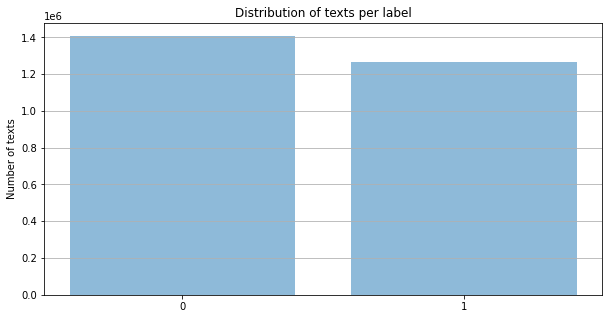

Counter({0: 1407550, 1: 1266247})


In [6]:
categories = df[['label']].values.reshape(-1)

counter_categories = Counter(categories)
label_names = counter_categories.keys()
label_values = counter_categories.values()

y_pos = np.arange(len(label_names))

plt.figure(1, figsize=(10, 5))
plt.bar(y_pos, label_values, align='center', alpha=0.5)
plt.xticks(y_pos, label_names)
plt.ylabel('Number of texts')
plt.title('Distribution of texts per label')
plt.gca().yaxis.grid(True)
plt.show()

print(counter_categories)

In [7]:
n_texts = len(X_data)
print('Texts in dataset: %d' % n_texts)

categories = df['label'].unique()
n_categories = len(categories)
print('Number of categories: %d' % n_categories)

print('Done!')

Texts in dataset: 2673797
Number of categories: 2
Done!


# Tokenize & encode

I am going to import the RoBERTa model from HuggingFace. Note that I must import not only the model but also the tokenizer (since I must use the same vocabulary as the model was trained with).

We should take into account that RoBERTa's input accepts up-to 512 tokens, thus **we must truncate the tokenized texts**. In my case, I truncate to 256 tokens, but you can put a higher value in the variable `MAX_LEN`.

See https://huggingface.co/roberta-base

In [8]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [9]:
# Transform categories into numbers
label_to_id = {}
label_to_name = {}

for index, c in enumerate(y_data):
    if c in label_to_id:
        label_id = label_to_id[c]
    else:
        label_id = len(label_to_id)
        label_to_id[c] = label_id
        label_to_name[label_id] = c
    
    y_data[index] = label_id

# Display dictionary
label_to_name

{0: 0, 1: 1}

In [10]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [11]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [12]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

## Create RoBERTa model

In [13]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [14]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 35)]         0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode TFBaseModelOutputWit 124645632   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

## Train model

This is basic training of RoBERTa but, if your dataset is larger, you may use K-Folds in this section. In this notebook, I use K-Folds (use it as inspiration): https://www.kaggle.com/dimasmunoz/clean-english-data-roberta ;)

In [15]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/2
29245/29245 [==============================] - 1987s 66ms/step - loss: 0.1005 - accuracy: 0.9633 - val_loss: 0.0706 - val_accuracy: 0.9749
Epoch 2/2
29245/29245 [==============================] - 1876s 64ms/step - loss: 0.0652 - accuracy: 0.9765 - val_loss: 0.0677 - val_accuracy: 0.9762


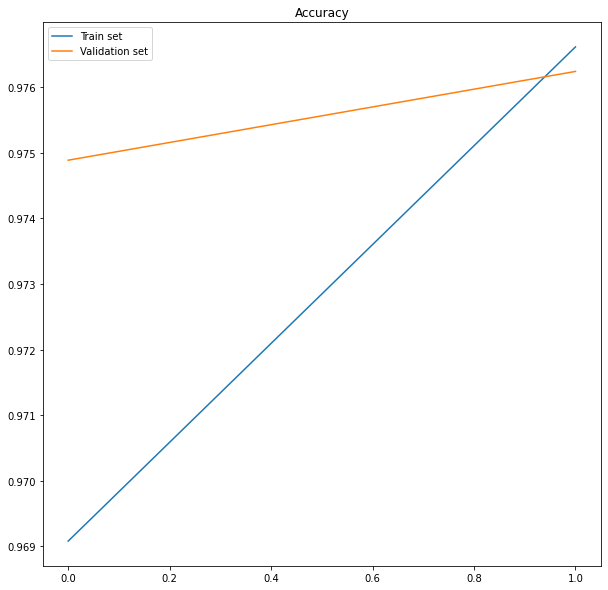

In [16]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()

## Evaluation

In a confusion matrix, we can see how many categories are classified c

In [17]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names, 
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 97.62%


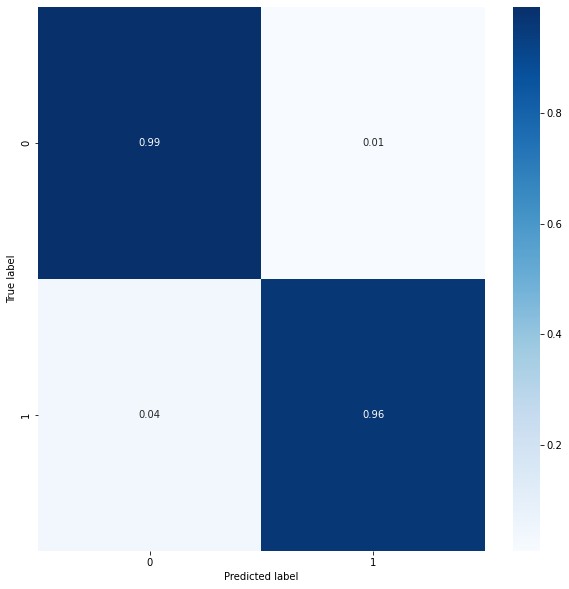

In [19]:
plot_confusion_matrix(X_test, y_test, model)

In [20]:
model.save_weights("model.h5")